In [ ]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import requests
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm
import random
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import accuracy_fn
device="cuda" if torch.cuda.is_available() else "cpu" #cuda uses gpu

In [ ]:
train_data=torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data=torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34208387.63it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1294032.69it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8132114.12it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8127358.69it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
testimg, testlabel = train_data[0]
testimg.shape

torch.Size([1, 28, 28])

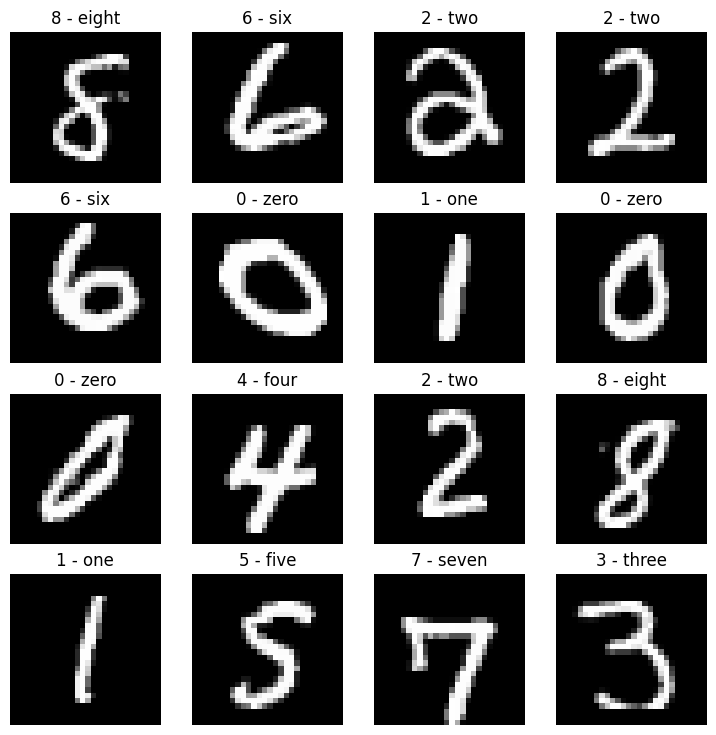

In [ ]:
torch.manual_seed(10)
class_names=train_data.classes
fig = plt.figure(figsize=(9,9))
rows, cols=4,4
for i in range(1, rows*cols+1):
  random_idx=torch.randint(0, len(train_data), size=[1]).item()
  img, label=train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

In [ ]:
BATCH_SIZE=32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} in batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} in batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7d8578447130>, <torch.utils.data.dataloader.DataLoader object at 0x7d85784454b0>)
Length of train dataloader: 1875 in batches of 32
Length of test dataloader: 313 in batches of 32


In [ ]:
train_features_batch, train_labels_batch=next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
flatten_model=nn.Flatten() #all nn modules function as a model because they can do a forward pass
x=train_features_batch[0] #a single sample
output=flatten_model(x) #perform forward pass
print(f"Shape before flattening: {x.shape}->[color_channels, height, width]")
print(f"Shape after flattening: {output.shape}->[color_channels,height*width]")

Shape before flattening: torch.Size([1, 28, 28])->[color_channels, height, width]
Shape after flattening: torch.Size([1, 784])->[color_channels,height*width]


In [ ]:
class ClassificationModel(nn.Module):
  # TinyVGG model architecture from:
  # https://poloclub.github.io/cnn-explainer/
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block_1=nn.Sequential(nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                               nn.ReLU(),
                               nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size=2, stride=2))
    self.block_2=nn.Sequential(nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
                               nn.ReLU(),
                               nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
                               nn.MaxPool2d(2))
    self.classifier=nn.Sequential(nn.Flatten(), nn.Linear(in_features=hidden_units*7*7, out_features=output_shape))

  def forward(self, x: torch.Tensor):
    x=self.block_1(x)
    x=self.block_2(x)
    x=self.classifier(x)
    return x

In [ ]:
torch.manual_seed(10)
classifier_model=ClassificationModel(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
classifier_model

ClassificationModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
def train_step(model: nn.Module, data_loader: DataLoader, loss_fn:nn.Module, optimizer:torch.optim.Optimizer, accuracy_fn, device:torch.device=device):
  train_loss, train_acc=0, 0
  model.to(device)
  for batch, (X, y) in enumerate(data_loader):
    #send data to GPU
    X, y = X.to(device), y.to(device)
    #forward pass
    y_pred=model(X)
    #calculate loss
    loss=loss_fn(y_pred, y)
    train_loss+=loss
    train_acc+=accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) #go from logits to predicted labels
    #optimizer zero grad to clear the gradients from previous passes
    optimizer.zero_grad()
    #loss backward to calculate the gradients
    loss.backward()
    #optimizer step to update the weights
    optimizer.step()
  #per epoch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

def test_step(data_loader: torch.utils.data.DataLoader, model:nn.Module, loss_fn: nn.Module, accuracy_fn, device: torch.device=device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred=model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}")

helper_functions.py already exists, skipping download


In [ ]:
def print_train_time(start:float, end: float, device: torch.device=None):
  total_time=end-start
  print(f"Train time: {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=classifier_model.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(10)
train_time_start_classifier_model=timer()

epochs = 3
#train and test classifier model
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n-----------------")
  train_step(data_loader=train_dataloader, model=classifier_model, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
  test_step(data_loader=test_dataloader, model=classifier_model, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

train_time_end_classifier_model=timer()
total_train_time_classifier_model=print_train_time(start=train_time_start_classifier_model, end=train_time_end_classifier_model, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
-----------------
Train loss: 0.29124 | Train accuracy: 90.63
Test loss: 0.08243 | Test accuracy: 97.47
Epoch: 1 
-----------------
Train loss: 0.07066 | Train accuracy: 97.81
Test loss: 0.06454 | Test accuracy: 97.68
Epoch: 2 
-----------------
Train loss: 0.05566 | Train accuracy: 98.29
Test loss: 0.05742 | Test accuracy: 97.97
Train time: cuda: 35.978 seconds


In [ ]:
def make_predictions(model:nn.Module, data: list, device: torch.device=device):
  pred_probs=[]
  model.to(device).eval()
  with torch.inference_mode():
    for sample in data:
      sample=torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob=torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

In [ ]:
random.seed(10)
test_samples=[]
test_labels=[]
for sample, label in random.sample(list(test_data), k=20):
  test_samples.append(sample)
  test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]}")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 6


In [ ]:
pred_probs=make_predictions(model=classifier_model, data=test_samples, device=device)
pred_probs[:2]

tensor([[2.5100e-05, 2.6376e-10, 3.5628e-08, 1.4348e-10, 4.5258e-07, 2.1208e-06,
         9.9997e-01, 5.1623e-11, 1.0485e-06, 1.3773e-09],
        [5.1878e-07, 1.3255e-07, 1.1958e-06, 2.7464e-10, 9.9997e-01, 4.8491e-07,
         1.3395e-06, 2.5102e-05, 2.5996e-06, 1.9206e-07]])

In [ ]:
pred_classes=pred_probs.argmax(dim=1)
pred_classes
test_labels, pred_classes

([6, 4, 3, 6, 4, 7, 7, 5, 5, 2, 2, 8, 8, 0, 1, 0, 9, 1, 7, 9],
 tensor([6, 4, 3, 6, 4, 7, 7, 5, 5, 2, 2, 8, 8, 0, 1, 0, 9, 1, 7, 9]))

<ipython-input-113-c092b1b89ebe>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3,3))


<Figure size 900x900 with 0 Axes>

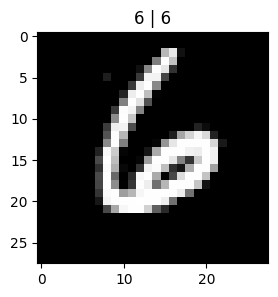

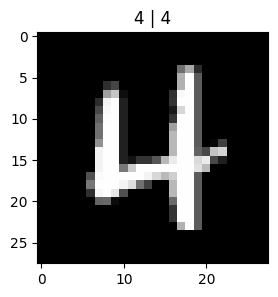

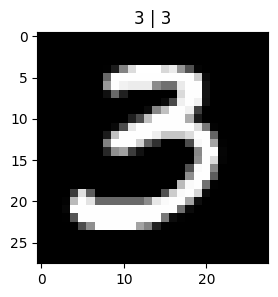

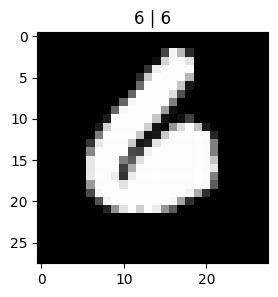

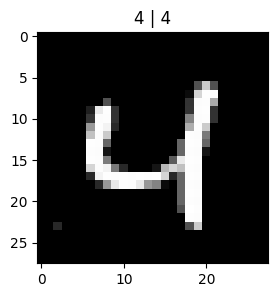

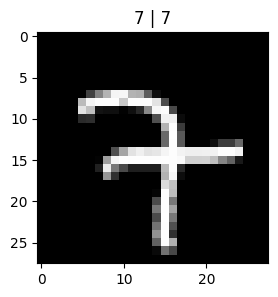

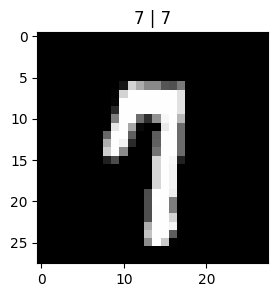

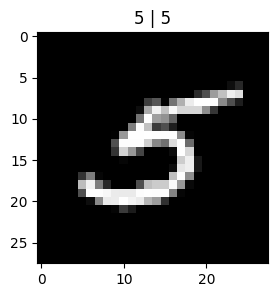

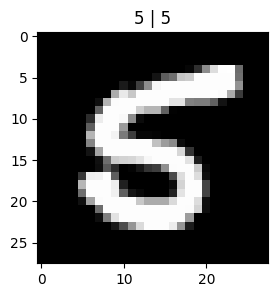

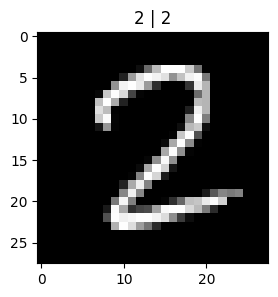

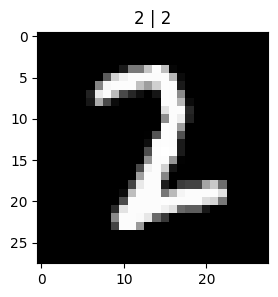

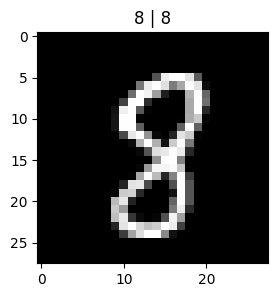

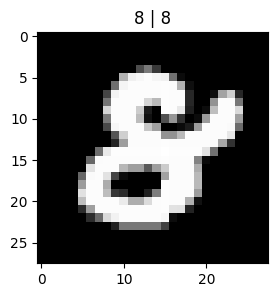

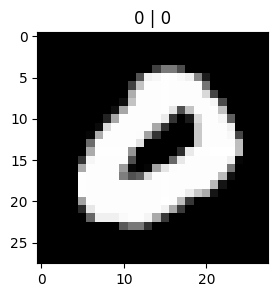

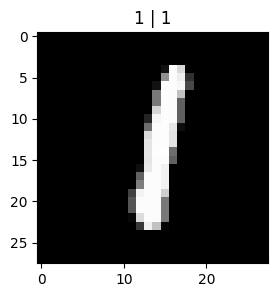

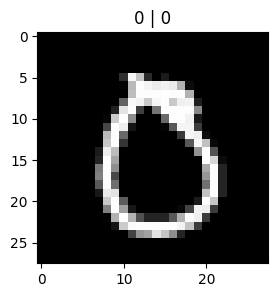

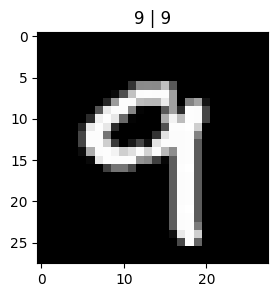

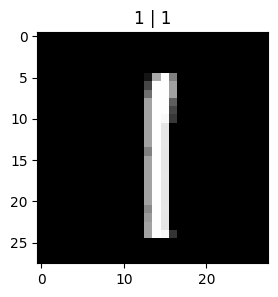

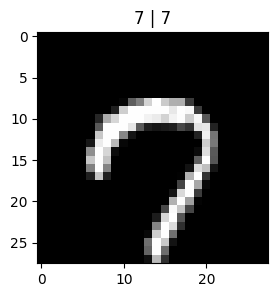

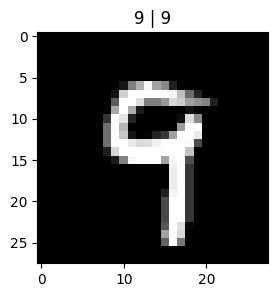

In [ ]:
plt.figure(figsize=(9,9))
nrows=3
ncols=3
for i, sample in enumerate(test_samples):
  plt.figure(figsize=(3,3))
  plt.imshow(sample.squeeze(), cmap="gray")
  plt.title(f"{pred_classes[i]} | {test_labels[i]}")